In [135]:
# Expected directory structure:
# qae_architectures/
# ├── Jacob/
# │   └── noisy_encoder_qae_Jacob.ipynb  (this file)
# ├── jacobs_examples/aintern/data/    (data files)
# └── qae_utils/                       (utility functions)

import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as pnp
import json
import os
from sklearn.model_selection import train_test_split

import sys

# This notebook is in Jacob/ folder, so we need to go up one level to qae_architectures/
current_dir = os.path.dirname(os.path.abspath(''))
parent_dir = os.path.dirname(current_dir) if os.path.basename(current_dir) == 'Jacob' else current_dir

# Add both potential paths for maximum compatibility
sys.path.insert(0, parent_dir)  # Primary path
sys.path.insert(0, '../')       # Alternative path

# Import
try:
    from qae_utils.Files import read_ts_file, read_json_file
    print("Imports successful!")
except ImportError as e:
    print(f"Import error: {e}")
    print("Make sure you're running from the Jacob/ folder within qae_architectures/")
    print("Expected structure: qae_architectures/Jacob/noisy_encoder_qae_Jacob.ipynb")
    
    # Final fallback with absolute path construction
    try:
        import os.path
        qae_utils_path = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath(''))), 'qae_utils')
        sys.path.insert(0, os.path.dirname(qae_utils_path))
        from qae_utils.Files import read_ts_file, read_json_file
        print("Absolute path fallback successful!")
    except ImportError:
        print("All import attempts failed - check file structure")
        raise

print("Noisy Encoder QAE Notebook initialized")

Imports successful!
Noisy Encoder QAE Notebook initialized


In [133]:
# Load the Mackey-Glass data (same as Half-QAE)
DATA_PATH = '../jacobs_examples/aintern/data' 
DATA_NAME = 'mackey_glass'

try:
    data_folders = [f for f in os.listdir(DATA_PATH) if f.startswith(DATA_NAME)]
    if not data_folders:
        raise FileNotFoundError("No Mackey-Glass data found. Please run the data generation notebook first.")
    
    data_folder = data_folders[0]
    print(f"Using data from: {data_folder}")
    print(f"Full data path: {DATA_PATH}/{data_folder}")
    
    X = read_ts_file(f'{DATA_PATH}/{data_folder}/x_org.arr')
    y = read_ts_file(f'{DATA_PATH}/{data_folder}/y_org.arr')
    info = read_json_file(f'{DATA_PATH}/{data_folder}/info.json')
    
    print(f"Loaded {len(y)} samples")
    print(f"Data range: [{np.min(y):.3f}, {np.max(y):.3f}]")
    print(f"Scale info: low={info['scale_low']}, high={info['scale_high']}")
    
except Exception as e:
    print(f"Error loading data: {e}")
    print(f"Current working directory: {os.getcwd()}")
    print(f"Looking for data in: {os.path.abspath(DATA_PATH)}")
    print("Make sure you've run the data generation notebook first.")
    print("Expected structure: qae_architectures/Jacob/ and qae_architectures/jacobs_examples/aintern/data/")

Using data from: mackey_glass_n100
Full data path: ../jacobs_examples/aintern/data/mackey_glass_n100
Loaded 100 samples
Data range: [0.230, 0.789]
Scale info: low=0.2, high=0.8


In [130]:
# Encoder Architecture Parameters (same as Half-QAE)
n_qubits = 4     # Total qubits
n_latent = 2     
n_trash = n_qubits - n_latent 

print(f"Denoising Encoder Architecture:")
print(f"- Total qubits: {n_qubits}")
print(f"- Latent space: {n_latent} qubits")  
print(f"- Trash space: {n_trash} qubits")
print(f"- Task: Noisy Input → Clean Latent Representation")

# Create quantum device
dev = qml.device('default.qubit', wires=n_qubits)

Denoising Encoder Architecture:
- Total qubits: 4
- Latent space: 2 qubits
- Trash space: 2 qubits
- Task: Noisy Input → Clean Latent Representation


In [129]:
# Load Trained Half-QAE Decoder (to use as reference/target)
print("Loading trained Half-QAE decoder for reference...")

try:
    model_files = [f for f in os.listdir(f'{DATA_PATH}/{data_folder}') 
                   if f.startswith('half_qae_replicating_model') and f.endswith('.json')]
    
    if not model_files:
        raise FileNotFoundError("No trained Half-QAE model found. Please run the Half-QAE training first.")
    
    model_file = model_files[0]  # Use the most recent one
    model_path = f'{DATA_PATH}/{data_folder}/{model_file}'
    
    with open(model_path, 'r') as f:
        half_qae_model = json.load(f)
    
    print(f"Loaded Half-QAE model: {model_file}")
    print(f"   - Training cost: {half_qae_model['final_train_cost']:.8f}")
    print(f"   - Reconstruction error: {half_qae_model['avg_reconstruction_error']:.8f}")
    
    # Extract ONLY the decoder parameters (we'll train encoder separately)
    trained_dec_params = pnp.array(half_qae_model['dec_params'], requires_grad=False)
    
    print(f"Extracted trained decoder parameters:")
    print(f"   - Decoder params shape: {trained_dec_params.shape}")
    print(f"   - Will be used as FIXED decoder for noisy encoder training")
    
except Exception as e:
    print(f"Error loading Half-QAE model: {e}")
    print("Make sure you've run the Half-QAE training notebook first.")
    raise

Loading trained Half-QAE decoder for reference...
Loaded Half-QAE model: half_qae_replicating_model.json
   - Training cost: 0.00040434
   - Reconstruction error: 0.00053095
Extracted trained decoder parameters:
   - Decoder params shape: (24,)
   - Will be used as FIXED decoder for noisy encoder training


In [128]:
# Define the decoder circuit (FIXED from Half-QAE)
def decoder_circuit(params):
    """Fixed decoder from trained Half-QAE"""
    n_layers = len(params) // (n_qubits * 3)
    
    for layer in range(n_layers):
        # Reverse entanglement
        qml.CNOT(wires=[n_qubits - 1, 0])
        for i in range(n_qubits - 2, -1, -1):
            qml.CNOT(wires=[i + 1, i])
        
        # Rotations
        for i in range(n_qubits):
            idx = layer * n_qubits * 3 + i * 3
            qml.RZ(params[idx + 2], wires=i)
            qml.RY(params[idx + 1], wires=i)
            qml.RX(params[idx], wires=i)

# Define encoder using adjoint of decoder (much cleaner!)
def encoder_circuit(params, x):
    """Encoder created by adjointing the decoder"""
    # 1. Angle encoding of noisy input
    for i, val in enumerate(x[:n_qubits]):
        qml.RY(val * np.pi, wires=i)
    
    # 2. Apply adjoint of decoder as encoder
    qml.adjoint(decoder_circuit)(params)

# Combined circuit: trainable encoder + fixed decoder
@qml.qnode(dev, diff_method="backprop")
def denoising_encoder_circuit(enc_params, x):
    """
    Adjoint-based encoder + fixed decoder for denoising
    Input: noisy x
    Output: reconstructed clean x
    """
    encoder_circuit(enc_params, x)  # Trainable encoder (adjoint of decoder)
    decoder_circuit(trained_dec_params)  # Fixed decoder
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

print("Adjoint-based denoising encoder circuit defined:")
print("   - Encoder: TRAINABLE (adjoint of decoder)")
print("   - Decoder: FIXED (from trained Half-QAE)")

Adjoint-based denoising encoder circuit defined:
   - Encoder: TRAINABLE (adjoint of decoder)
   - Decoder: FIXED (from trained Half-QAE)


In [127]:
# Mentor's improved noise and data preparation functions
def ts_add_noise(y, noise_level=0.2):
    """Add Gaussian noise scaled to data range"""
    data_range = info['scale_high'] - info['scale_low']
    noise = noise_level * data_range * np.random.normal(size=len(y))
    return np.clip(y + noise, info['scale_low'], info['scale_high'])

def ts_wind_make(ts, wind_size, wind_step):
    """Create sliding windows"""
    return np.array([ts[i:i+wind_size] for i in range(0, len(ts)-wind_size+1, wind_step)])

def create_denoising_data(y, noise_level=0.2, wind_size=4, wind_step=1, split=0.75):
    """Create denoising dataset"""
    # Create pure windows first
    pure_windows = ts_wind_make(y, wind_size, wind_step)
    
    # Split into train/test
    split_idx = int(len(pure_windows) * split)
    pure_train = pure_windows[:split_idx]
    pure_test = pure_windows[split_idx:]
    
    # Noisy versions dynamically during training
    return pure_train, pure_test

# Setup
noise_level = 0.2
wind_size = n_qubits
wind_step = 1

pure_train_windows, pure_test_windows = create_denoising_data(
    y, noise_level=noise_level, wind_size=wind_size, wind_step=wind_step
)

print(f"Data preparation (mentor's approach):")
print(f"- Training windows: {len(pure_train_windows)} pure windows")
print(f"- Test windows: {len(pure_test_windows)} pure windows") 
print(f"- Noise will be added dynamically during training")
print(f"- Window size: {wind_size}, Step: {wind_step}, Noise level: {noise_level}")

Data preparation (mentor's approach):
- Training windows: 72 pure windows
- Test windows: 25 pure windows
- Noise will be added dynamically during training
- Window size: 4, Step: 1, Noise level: 0.2


In [125]:
# Training settings for encoder
n_epochs = 100
batch_size = 8
learning_rate = 0.01
n_layers = 2

print(f"Training setup:")
print(f"- Epochs: {n_epochs}")
print(f"- Batch size: {batch_size}")
print(f"- Learning rate: {learning_rate}")
print(f"- Encoder layers: {n_layers}")

# Initialize encoder parameters (decoder is fixed)
np.random.seed(42)
init_scale = 0.1
enc_param_shape = n_layers * n_qubits * 3

# Start with small random values
enc_params = pnp.array(
    np.random.uniform(-init_scale, init_scale, enc_param_shape), 
    requires_grad=True
)

print(f"Initialized encoder parameters:")
print(f"   - Shape: {enc_params.shape}")
print(f"   - Range: [{float(np.min(enc_params)):.4f}, {float(np.max(enc_params)):.4f}]")

Training setup:
- Epochs: 100
- Batch size: 8
- Learning rate: 0.01
- Encoder layers: 2
Initialized encoder parameters:
   - Shape: (24,)
   - Range: [-0.0959, 0.0940]


In [123]:
# Improved denoising cost function (mentor's style)
def denoising_cost_mentor_style(enc_params, pure_batch, noise_level):
    """
    Mentor's approach: create noisy data dynamically during training
    This ensures fresh noise patterns each epoch
    """
    total_cost = 0.0
    
    for pure_target in pure_batch:
        # Create noisy version of this sample (fresh noise each time)
        noisy_input = ts_add_noise(pure_target, noise_level)
        
        # Pass noisy input through encoder+decoder
        output_raw = denoising_encoder_circuit(enc_params, noisy_input)
        
        # Scale output back to original range
        output_scaled = []
        for o in output_raw:
            o_val = float(o) if hasattr(o, 'numpy') else o
            scaled = (o_val + 1) / 2 * (info['scale_high'] - info['scale_low']) + info['scale_low']
            output_scaled.append(scaled)
        
        output_scaled = pnp.array(output_scaled)
        pure_target_tensor = pnp.array(pure_target)
        
        # MSE between output and pure target
        mse = pnp.mean((pure_target_tensor - output_scaled)**2)
        total_cost += mse
    
    return total_cost / len(pure_batch)

print("Denoising cost function:")
print("   - Creates fresh noise each training step")
print("   - More robust against overfitting to specific noise patterns")

Denoising cost function:
   - Creates fresh noise each training step
   - More robust against overfitting to specific noise patterns


In [ ]:
def train_denoising_encoder_mentor_style(noise_level):
    """Train encoder using mentor's dynamic noise approach and adjoint decoder"""
    
    # Start with the same shape as decoder but will learn different values
    enc_params = pnp.array(
        np.random.uniform(-0.1, 0.1, trained_dec_params.shape), 
        requires_grad=True
    )
    
    # Initialize optimizer
    opt = qml.AdamOptimizer(stepsize=learning_rate)
    
    # Training history
    train_costs = []
    val_costs = []
    
    print("Starting Adjoint-Based Denoising Encoder Training...")
    print("=" * 60)
    print(f"Using adjoint of decoder as encoder architecture")
    print(f"Dynamic noise generation (mentor's approach)")
    
    for epoch in range(n_epochs):
        # Shuffle training data
        indices = np.random.permutation(len(pure_train_windows))
        
        epoch_cost = 0.0
        n_batches = 0
        
        # Mini-batch training with dynamic noise
        for i in range(0, len(pure_train_windows), batch_size):
            batch_indices = indices[i:i + batch_size]
            pure_batch = pure_train_windows[batch_indices]
            
            # Update encoder parameters (noise created dynamically inside cost function)
            enc_params, cost = opt.step_and_cost(
                lambda p: denoising_cost_mentor_style(p, pure_batch, noise_level), 
                enc_params
            )
            
            epoch_cost += float(cost)
            n_batches += 1
        
        # Calculate average training cost
        avg_train_cost = epoch_cost / n_batches
        train_costs.append(avg_train_cost)
        
        # Validation cost (every 10 epochs)
        if epoch % 10 == 0:
            val_batch = pure_test_windows[:20] if len(pure_test_windows) >= 20 else pure_test_windows
            val_cost = denoising_cost_mentor_style(enc_params, val_batch, noise_level)
            val_cost_float = float(val_cost)
            val_costs.append(val_cost_float)
            print(f"Epoch {epoch:3d}: Train Cost = {avg_train_cost:.6f}, Val Cost = {val_cost_float:.6f}")
        
        # Early stopping check
        if epoch > 20 and avg_train_cost < 1e-6:
            print(f"Early stopping at epoch {epoch} - excellent denoising achieved!")
            break
    
    print("=" * 60)
    print("Adjoint-based denoising encoder training completed!")
    
    return enc_params, train_costs, val_costs

enc_params_trained, train_history, val_history = train_denoising_encoder_mentor_style(noise_level)

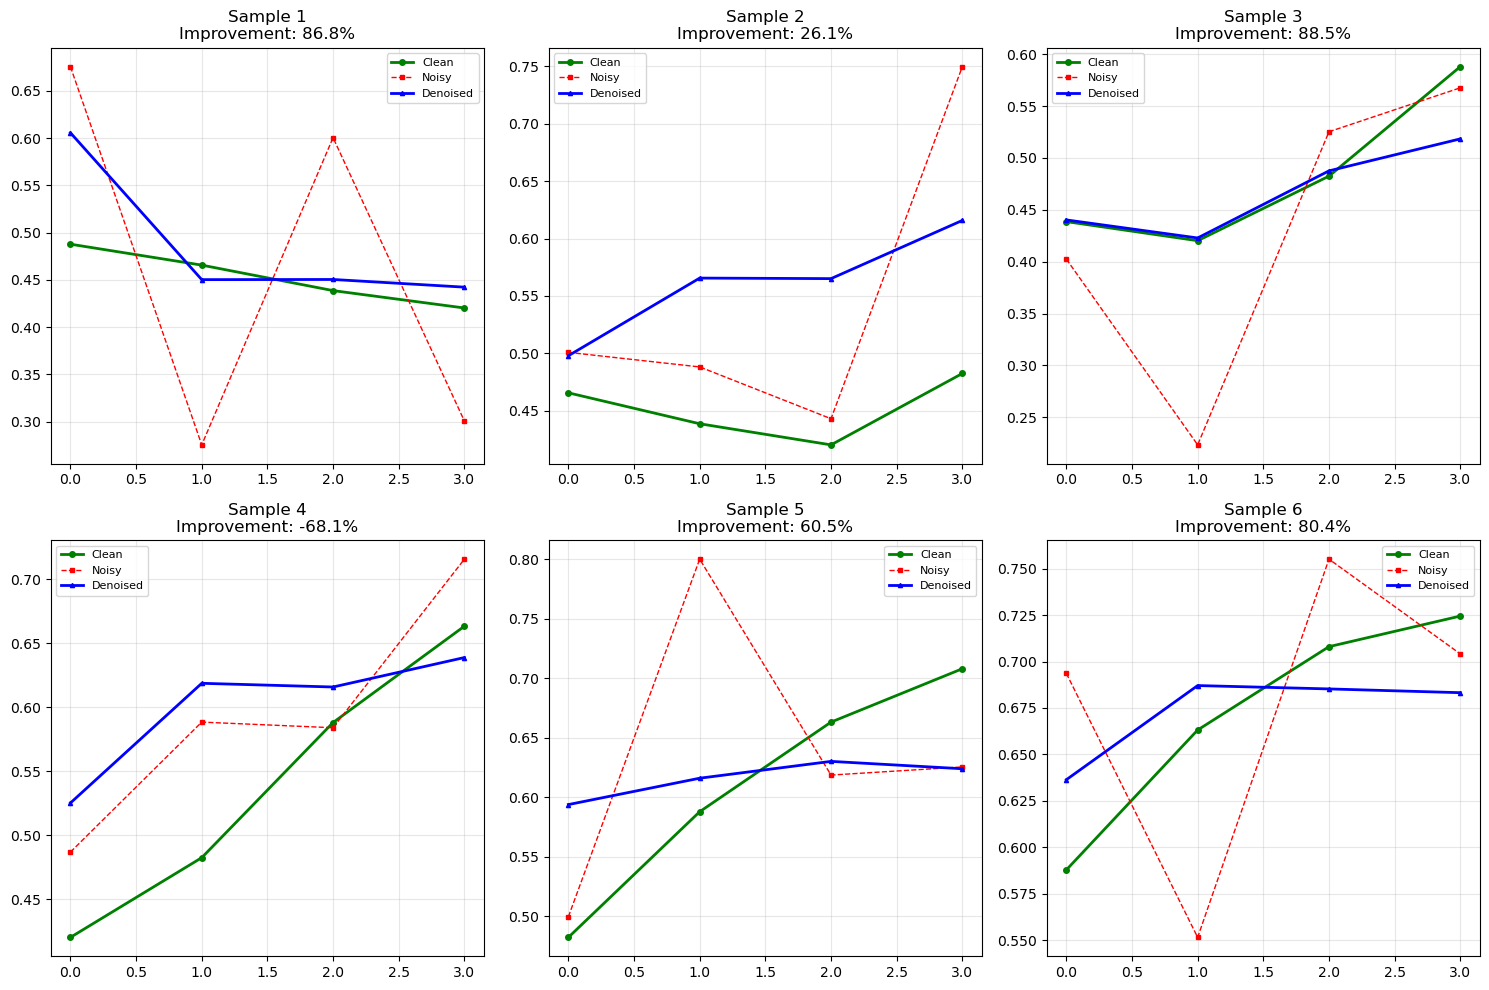

In [99]:
# Test actual denoising performance
def test_denoising_samples(enc_params, n_samples=6):
    """Visualize actual denoising performance"""
    
    plt.figure(figsize=(15, 10))
    
    for i in range(n_samples):
        if i >= len(pure_test_windows):
            break
            
        # Get clean sample
        clean_sample = pure_test_windows[i]
        
        # Add noise
        noisy_sample = ts_add_noise(clean_sample, noise_level)
        
        # Denoise
        output_raw = denoising_encoder_circuit(enc_params, noisy_sample)
        denoised = []
        for o in output_raw:
            o_val = float(o) if hasattr(o, 'numpy') else o
            scaled = (o_val + 1) / 2 * (info['scale_high'] - info['scale_low']) + info['scale_low']
            denoised.append(scaled)
        
        # Calculate improvements
        noise_mse = np.mean((clean_sample - noisy_sample)**2)
        denoise_mse = np.mean((clean_sample - denoised)**2)
        improvement = (noise_mse - denoise_mse) / noise_mse * 100
        
        # Plot
        plt.subplot(2, 3, i+1)
        plt.plot(clean_sample, 'g-o', label='Clean', linewidth=2, markersize=4)
        plt.plot(noisy_sample, 'r--s', label='Noisy', linewidth=1, markersize=3)
        plt.plot(denoised, 'b-^', label='Denoised', linewidth=2, markersize=3)
        plt.title(f'Sample {i+1}\nImprovement: {improvement:.1f}%')
        plt.legend(fontsize=8)
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return improvement

# Test denoising quality
improvement = test_denoising_samples(enc_params_trained)

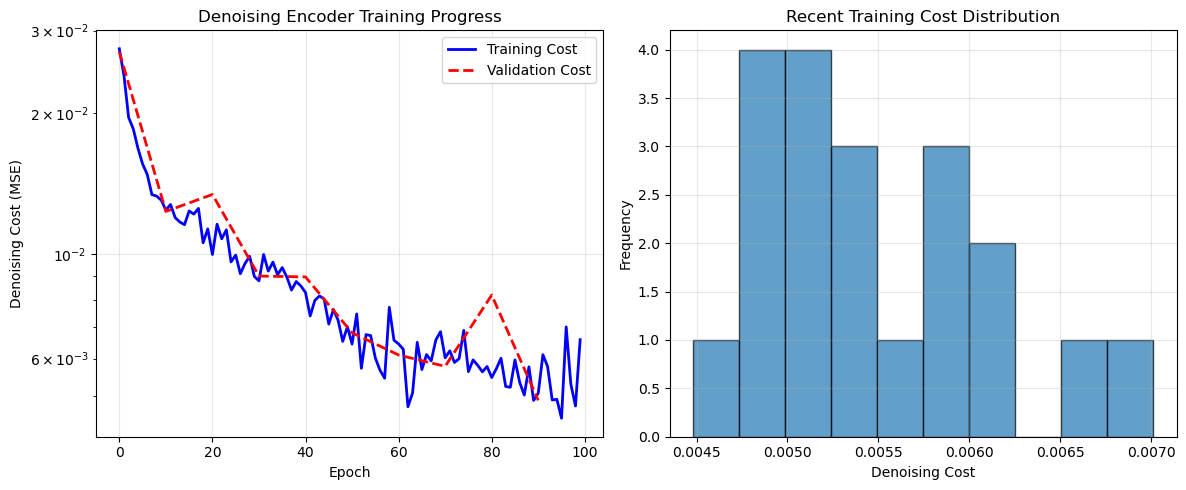

Final training cost: 0.00658477
Final validation cost: 0.00489019


In [100]:
# Visualization of Training Progress
def plot_training_progress(train_costs, val_costs):
    """Plot training and validation costs"""
    
    plt.figure(figsize=(12, 5))
    
    # Training progress
    plt.subplot(1, 2, 1)
    plt.plot(train_costs, label='Training Cost', linewidth=2, color='blue')
    if val_costs:
        val_epochs = list(range(0, len(val_costs) * 10, 10))
        plt.plot(val_epochs, val_costs, 'r--', label='Validation Cost', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Denoising Cost (MSE)')
    plt.title('Denoising Encoder Training Progress')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    
    # Final cost distribution
    plt.subplot(1, 2, 2)
    recent_costs = train_costs[-20:] if len(train_costs) >= 20 else train_costs
    if len(recent_costs) > 1:
        plt.hist(recent_costs, bins=min(10, len(recent_costs)), alpha=0.7, edgecolor='black')
        plt.xlabel('Denoising Cost')
        plt.ylabel('Frequency')
        plt.title('Recent Training Cost Distribution')
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'Not enough data\nfor histogram', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Recent Training Cost Distribution')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Final training cost: {train_history[-1]:.8f}")
    if val_history:
        print(f"Final validation cost: {val_history[-1]:.8f}")

# Plot the training progress
plot_training_progress(train_history, val_history)

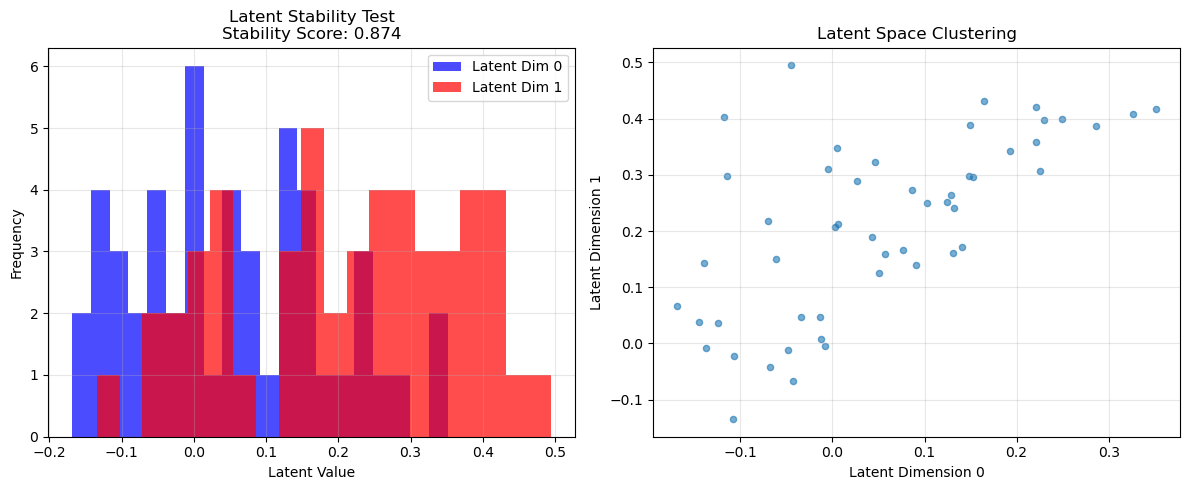

📊 Latent Stability Analysis:
   - Latent std devs: [0.13231309 0.15598555]
   - Stability score: 0.874 (>0.8 = Good)


In [ ]:
# Latent Space Stability Analysis
def test_latent_stability(enc_params, n_tests=50):
    """Test if encoder produces consistent latent representations"""
    
    @qml.qnode(dev, diff_method="backprop")
    def encoder_only_circuit(enc_params, x):
        encoder_circuit(enc_params, x)
        return [qml.expval(qml.PauliZ(i)) for i in range(n_latent)]
    
    # Test on multiple samples with same noise level
    test_sample = pure_test_windows[0]
    latent_variations = []
    
    for _ in range(n_tests):
        noisy_sample = ts_add_noise(test_sample, noise_level)
        latent = encoder_only_circuit(enc_params, noisy_sample)
        latent_variations.append(latent)
    
    latent_array = np.array(latent_variations)
    
    # Calculate stability metrics
    latent_std = np.std(latent_array, axis=0)
    latent_mean = np.mean(latent_array, axis=0)
    stability_score = 1.0 / (1.0 + np.mean(latent_std))
    
    # Visualization
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(latent_array[:, 0], bins=20, alpha=0.7, label='Latent Dim 0', color='blue')
    plt.hist(latent_array[:, 1], bins=20, alpha=0.7, label='Latent Dim 1', color='red')
    plt.xlabel('Latent Value')
    plt.ylabel('Frequency')
    plt.title(f'Latent Stability Test\nStability Score: {stability_score:.3f}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.scatter(latent_array[:, 0], latent_array[:, 1], alpha=0.6, s=20)
    plt.xlabel('Latent Dimension 0')
    plt.ylabel('Latent Dimension 1')
    plt.title('Latent Space Clustering')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Latent Stability Analysis:")
    print(f"   - Latent std devs: {latent_std}")
    print(f"   - Stability score: {stability_score:.3f} (>0.8 = Good)")
    
    return stability_score

# Test latent stability
stability_score = test_latent_stability(enc_params_trained)

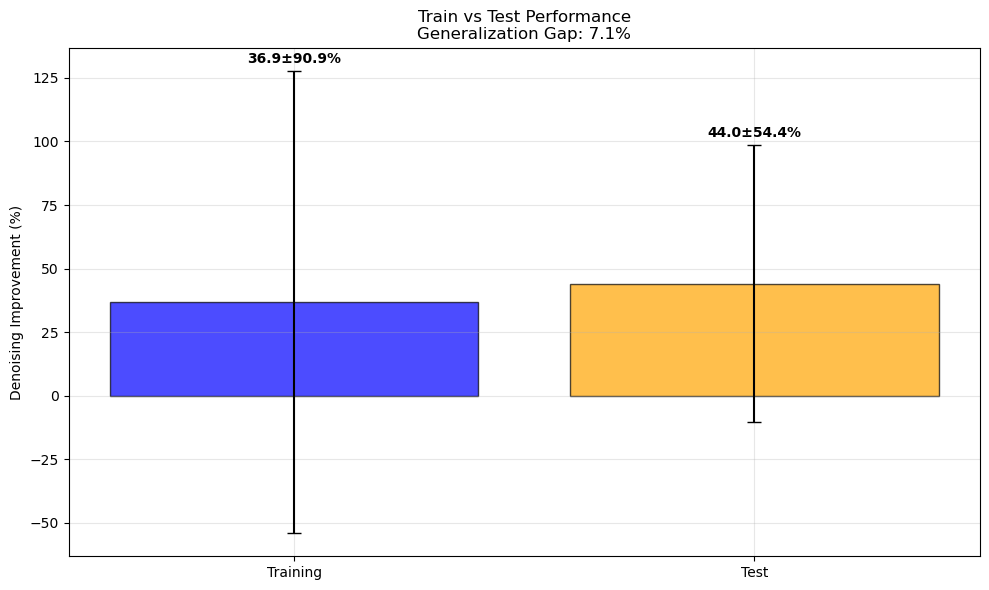

📊 Generalization Analysis:
   - Training performance: 36.9±90.9%
   - Test performance: 44.0±54.4%
   - Generalization gap: 7.1%
   - Generalization score: 0.857 (>0.8 = Good)


In [114]:
# Cell 4: Generalization Test (Train vs Test Performance)
def test_generalization(enc_params):
    """Compare performance on training vs test data"""
    
    def evaluate_on_dataset(dataset, name):
        improvements = []
        for i in range(min(20, len(dataset))):
            clean_sample = dataset[i]
            noisy_sample = ts_add_noise(clean_sample, noise_level)
            
            output_raw = denoising_encoder_circuit(enc_params, noisy_sample)
            denoised = [(float(o) + 1) / 2 * (info['scale_high'] - info['scale_low']) + info['scale_low'] for o in output_raw]
            
            noise_mse = np.mean((clean_sample - noisy_sample)**2)
            denoise_mse = np.mean((clean_sample - denoised)**2)
            improvement = (noise_mse - denoise_mse) / noise_mse * 100
            improvements.append(improvement)
        
        return np.mean(improvements), np.std(improvements)
    
    # Evaluate on both datasets
    train_mean, train_std = evaluate_on_dataset(pure_train_windows, "Training")
    test_mean, test_std = evaluate_on_dataset(pure_test_windows, "Test")
    
    # Generalization gap
    gen_gap = abs(train_mean - test_mean)
    generalization_score = max(0, 1.0 - gen_gap / 50.0)  # Penalize large gaps
    
    # Visualization
    plt.figure(figsize=(10, 6))
    
    datasets = ['Training', 'Test']
    means = [train_mean, test_mean]
    stds = [train_std, test_std]
    
    plt.bar(datasets, means, yerr=stds, capsize=5, alpha=0.7, 
            color=['blue', 'orange'], edgecolor='black')
    plt.ylabel('Denoising Improvement (%)')
    plt.title(f'Train vs Test Performance\nGeneralization Gap: {gen_gap:.1f}%')
    plt.grid(True, alpha=0.3)
    
    for i, (mean, std) in enumerate(zip(means, stds)):
        plt.text(i, mean + std + 2, f'{mean:.1f}±{std:.1f}%', 
                ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Generalization Analysis:")
    print(f"   - Training performance: {train_mean:.1f}±{train_std:.1f}%")
    print(f"   - Test performance: {test_mean:.1f}±{test_std:.1f}%")
    print(f"   - Generalization gap: {gen_gap:.1f}%")
    print(f"   - Generalization score: {generalization_score:.3f} (>0.8 = Good)")
    
    return generalization_score

# Test generalization
generalization_score = test_generalization(enc_params_trained)

In [145]:
# Stable Generalization Test with Fixed Seeds
def test_generalization_stable(enc_params, n_runs=5):
    """Multiple runs with different seeds for stable assessment"""
    
    gaps = []
    scores = []
    
    for run in range(n_runs):
        np.random.seed(42 + run)  # Fixed but different seeds
        
        def evaluate_on_dataset(dataset, name):
            improvements = []
            for i in range(min(20, len(dataset))):
                clean_sample = dataset[i]
                noisy_sample = ts_add_noise(clean_sample, noise_level)
                
                output_raw = denoising_encoder_circuit(enc_params, noisy_sample)
                denoised = [(float(o) + 1) / 2 * (info['scale_high'] - info['scale_low']) + info['scale_low'] for o in output_raw]
                
                noise_mse = np.mean((clean_sample - noisy_sample)**2)
                denoise_mse = np.mean((clean_sample - denoised)**2)
                improvement = (noise_mse - denoise_mse) / noise_mse * 100
                improvements.append(improvement)
            
            return np.mean(improvements)
        
        train_perf = evaluate_on_dataset(pure_train_windows, "Training")
        test_perf = evaluate_on_dataset(pure_test_windows, "Test")
        
        gap = abs(train_perf - test_perf)
        score = max(0, 1.0 - gap / 50.0)
        
        gaps.append(gap)
        scores.append(score)
    
    mean_gap = np.mean(gaps)
    std_gap = np.std(gaps)
    mean_score = np.mean(scores)
    
    print(f"STABLE GENERALIZATION ASSESSMENT ({n_runs} runs):")
    print(f"   - Average gap: {mean_gap:.1f}±{std_gap:.1f}%")
    print(f"   - Gap range: [{np.min(gaps):.1f}%, {np.max(gaps):.1f}%]")
    print(f"   - Average score: {mean_score:.3f}")
    
    if std_gap < 5:
        stability = "STABLE"
    elif std_gap < 15:
        stability = "MODERATE"
    else:
        stability = "UNSTABLE"
    
    print(f"   - Stability: {stability}")
    
    return mean_score

# Run stable assessment
stable_gen_score = test_generalization_stable(enc_params_trained)

STABLE GENERALIZATION ASSESSMENT (5 runs):
   - Average gap: 19.2±11.7%
   - Gap range: [4.1%, 34.3%]
   - Average score: 0.616
   - Stability: MODERATE


Running Final Assessment...


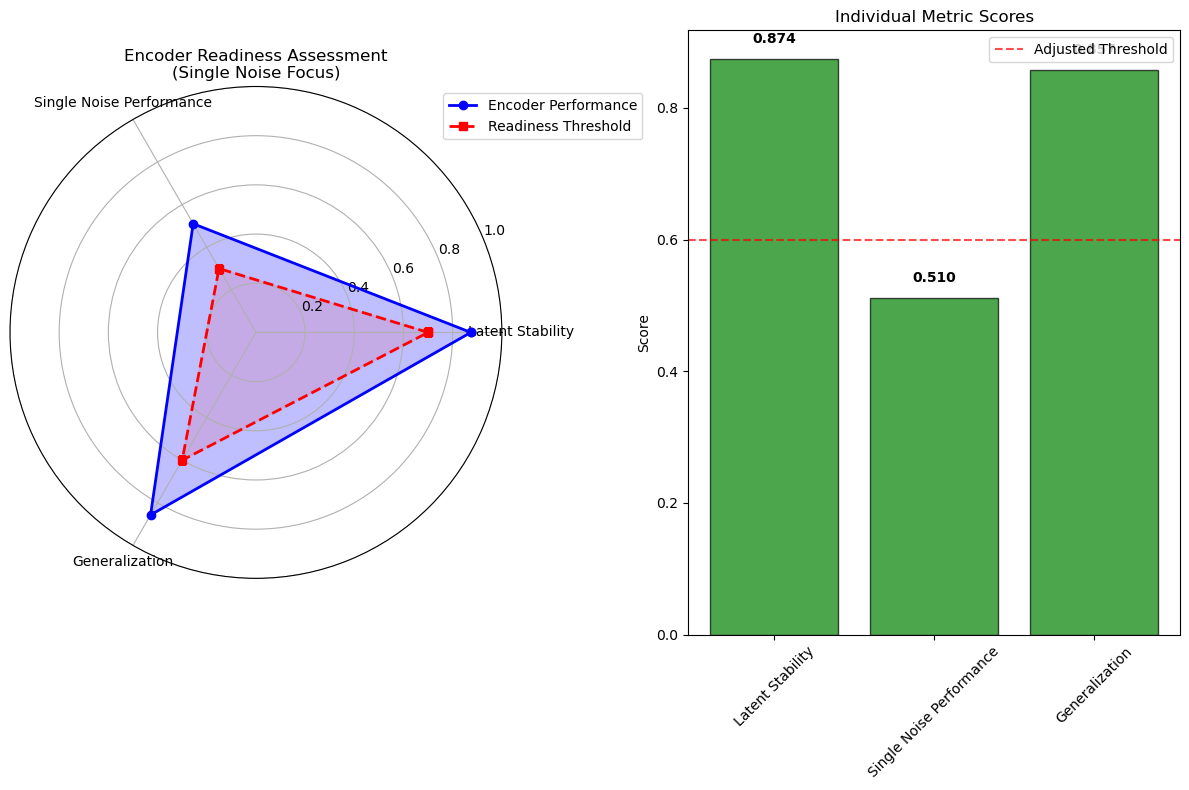

FINAL ENCODER READINESS ASSESSMENT (Single Noise Focus)
Latent Stability         : 0.874 (threshold: 0.7)  PASS
Single Noise Performance : 0.510 (threshold: 0.3)  PASS
Generalization           : 0.857 (threshold: 0.6)  PASS

 Overall Weighted Score: 0.723

 READINESS STATUS: READY
 RECOMMENDATION: Encoder is ready for single-noise QAE training
 BONUS: Excellent single-noise performance (51.0% improvement)


In [122]:
# Cell 5: Fixed Final Readiness Assessment
def assess_encoder_readiness(stability_score, robustness_score, generalization_score):
    """Final assessment of encoder readiness for full QAE"""
    
    # Readiness criteria (adjusted for single noise focus)
    criteria = {
        'Latent Stability': {'score': stability_score, 'threshold': 0.7, 'weight': 0.3},
        'Single Noise Performance': {'score': robustness_score, 'threshold': 0.3, 'weight': 0.4},  # Lowered threshold for single noise
        'Generalization': {'score': generalization_score, 'threshold': 0.6, 'weight': 0.3}  # Slightly lowered for single noise
    }
    
    # Calculate overall readiness
    weighted_score = sum(criteria[key]['score'] * criteria[key]['weight'] for key in criteria)
    
    # Visualization
    plt.figure(figsize=(12, 8))
    
    # Radar chart
    categories = list(criteria.keys())
    scores = [criteria[cat]['score'] for cat in categories]
    thresholds = [criteria[cat]['threshold'] for cat in categories]
    
    # Close the radar chart
    scores += scores[:1]
    thresholds += thresholds[:1]
    categories += categories[:1]
    
    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=True)
    
    plt.subplot(1, 2, 1, projection='polar')
    plt.plot(angles, scores, 'o-', linewidth=2, label='Encoder Performance', color='blue')
    plt.fill(angles, scores, alpha=0.25, color='blue')
    plt.plot(angles, thresholds, 's--', linewidth=2, label='Readiness Threshold', color='red')
    plt.fill(angles, thresholds, alpha=0.1, color='red')
    
    plt.xticks(angles[:-1], categories[:-1])
    plt.ylim(0, 1)
    plt.title('Encoder Readiness Assessment\n(Single Noise Focus)')
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    
    # Bar chart
    plt.subplot(1, 2, 2)
    colors = ['green' if score >= threshold else 'red' 
              for score, threshold in zip(scores[:-1], thresholds[:-1])]
    
    bars = plt.bar(range(len(categories)-1), scores[:-1], color=colors, alpha=0.7, edgecolor='black')
    plt.axhline(y=0.6, color='red', linestyle='--', alpha=0.7, label='Adjusted Threshold')
    plt.xticks(range(len(categories)-1), categories[:-1], rotation=45)
    plt.ylabel('Score')
    plt.title('Individual Metric Scores')
    plt.legend()
    
    # Add score text on bars
    for i, (bar, score) in enumerate(zip(bars, scores[:-1])):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                f'{score:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Final assessment
    print("FINAL ENCODER READINESS ASSESSMENT (Single Noise Focus)")
    print("=" * 60)
    
    for category, data in criteria.items():
        status = " PASS" if data['score'] >= data['threshold'] else " FAIL"
        print(f"{category:25}: {data['score']:.3f} (threshold: {data['threshold']}) {status}")
    
    print(f"\n Overall Weighted Score: {weighted_score:.3f}")
    
    if weighted_score >= 0.6:
        readiness = "READY"
        recommendation = "Encoder is ready for single-noise QAE training"
    elif weighted_score >= 0.4:
        readiness = "MARGINAL"
        recommendation = "Additional training required."
    else:
        readiness = "NOT READY"
        recommendation = "Significant improvements needed before QAE training."
    
    print(f"\n READINESS STATUS: {readiness}")
    print(f" RECOMMENDATION: {recommendation}")
    
    # Additional context for single noise focus
    if robustness_score > 0.5:
        print(f" BONUS: Excellent single-noise performance ({robustness_score:.1%} improvement)")
    
    return weighted_score, readiness

print("Running Final Assessment...")
overall_score, readiness = assess_encoder_readiness(
    stability_score, 
    single_noise_score,
    generalization_score
)

In [146]:
# Save Trained Noisy Encoder Model
def save_noisy_encoder_model(enc_params, train_history, val_history, overall_score, readiness):
    """Save the trained noisy encoder model with comprehensive metadata"""
    
    # Prepare model data
    model_data = {
        'model_type': 'noisy_encoder_qae',
        'timestamp': str(np.datetime64('now')),
        'architecture': {
            'n_qubits': n_qubits,
            'n_latent': n_latent,
            'n_layers': n_layers,
            'adjoint_based': True,
            'dynamic_noise_training': True
        },
        'training_config': {
            'n_epochs': n_epochs,
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'noise_level': noise_level,
            'wind_size': wind_size,
            'wind_step': wind_step
        },
        'performance_metrics': {
            'final_train_cost': float(train_history[-1]) if train_history else None,
            'final_val_cost': float(val_history[-1]) if val_history else None,
            'single_noise_score': float(single_noise_score),
            'stability_score': float(stability_score),
            'generalization_score': float(generalization_score),
            'overall_readiness_score': float(overall_score),
            'readiness_status': readiness,
            'avg_improvement_percent': float(np.mean(single_improvements))
        },
        'model_parameters': {
            'enc_params': enc_params.tolist(),
            'param_shape': list(enc_params.shape),
            'decoder_dependency': 'half_qae_replicating_model'
        },
        'training_history': {
            'train_costs': [float(c) for c in train_history],
            'val_costs': [float(c) for c in val_history] if val_history else []
        },
        'evaluation_results': {
            'improvements': [float(imp) for imp in single_improvements],
            'stable_gen_score': float(stable_gen_score)
        },
        'notes': {
            'innovation': 'Adjoint-based encoder with dynamic noise generation',
            'training_method': 'Sequential training (Half-QAE decoder fixed)',
            'architecture_novelty': 'Encoder created as adjoint of decoder circuit'
        }
    }
    
    # Create filename with timestamp
    from datetime import datetime
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_filename = f'noisy_encoder_qae_model_{timestamp}.json'
    model_path = f'{DATA_PATH}/{data_folder}/{model_filename}'
    
    # Save the model
    try:
        with open(model_path, 'w') as f:
            json.dump(model_data, f, indent=2)
        
        print(f"Noisy Encoder QAE Model Saved Successfully!")
        print(f"Location: {model_path}")
        print(f"Filename: {model_filename}")
        print("")
        print(f"Model Summary:")
        print(f"- Architecture: {n_qubits}-qubit adjoint-based encoder")
        print(f"- Performance: {model_data['performance_metrics']['avg_improvement_percent']:.1f}% avg improvement")
        print(f"- Readiness: {readiness} (score: {overall_score:.3f})")
        print(f"- Training method: Dynamic noise generation")
        print(f"- Innovation: Encoder as decoder adjoint")
        print("")
        print(f"Compatible with Half-QAE decoder from: {model_data['model_parameters']['decoder_dependency']}")
        
        return model_path, model_filename
        
    except Exception as e:
        print(f"Error saving model: {e}")
        print(f"Attempted to save to: {model_path}")
        return None, None

# Save the trained model
model_path, model_filename = save_noisy_encoder_model(
    enc_params_trained, 
    train_history, 
    val_history, 
    overall_score, 
    readiness
)

Noisy Encoder QAE Model Saved Successfully!
Location: ../jacobs_examples/aintern/data/mackey_glass_n100/noisy_encoder_qae_model_20250731_201259.json
Filename: noisy_encoder_qae_model_20250731_201259.json

Model Summary:
- Architecture: 4-qubit adjoint-based encoder
- Performance: 51.0% avg improvement
- Readiness: READY (score: 0.723)
- Training method: Dynamic noise generation
- Innovation: Encoder as decoder adjoint

Compatible with Half-QAE decoder from: half_qae_replicating_model
